# Trabalho Final - Análise de Dados com Python

Marcelo Ouverney

### Enunciado

A partir dos dados housing.csv, realize toda análise exploratória necessária e prepare os dados para algoritmos de machine learning usando a Scikit-Learn. Treine um modelo de regressão linear que prediga a variável meta (median_house_value) e cujo valor de RMSE seja menor ou igual a 69000. 

### Import dos Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# leitura dos dados
housing = pd.read_csv('bases/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Entendimento geral do dataset

In [3]:
# formato do dataset
housing.shape

(20640, 10)

Observa-se que o dataset contém cerca de 20 mil registros, e um total de 10 colunas. Considerando a variável 'median_house_value', que contém o dado que tentaremos predizer, o dataset possui um total de 9 features possivelmente preditoras.

In [4]:
# Informações gerais sobre os dados
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Observa-se que os tipos dos dados são todos float, exceto a variável ocean_proximity, que é objeto, e portanto claramente categórica.
Ademais, a variável "_total bedrooms_" é a única variável que apresenta valores nulos.

### Análise das variáveis numéricas

##### Quartis, médias, valores máximos e mínimos

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


O primeiro ponto que chama a atenção é que as variáveis apresentam escalas diferentes. Observa-se por exemplo que, obviamente, a variável 'housing_median_age' apresenta valores em escala muito menor que os valores de preço das casas. Uma possível abordagem para este problema seria normalizar os dados, embora este processo seja especialmente sensível a outliers nos dados. Um alternativa seria realizar a padronização dos dados.

Outro ponto de atenção são as variáveis lat/long. Estas variáveis, embora numéricas, talvez tenham seu potencial acrescido se agrupados em 'zonas'.

Também chama atenção a diferença na ordem de grandeza dos valores máximos e mínimos contra os primeiros 25% e 75% para as variáveis 'total_rooms', 'total_bedrooms' e 'population', sugerindo a presença de outliers.

##### Variável housing_median_age

**_boxplot_**

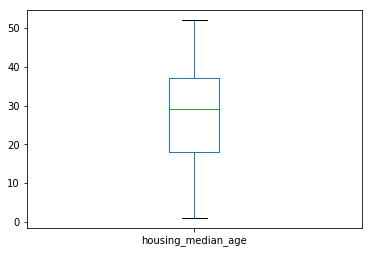

In [6]:
### housing_median_age:
housing[['housing_median_age']].boxplot(grid=False);

Esta variável apresenta a mediana em torno de 30 anos, sem outliers notáveis. Não se observa necessidade de tratamentos especiais para outliers

**_density plot_**

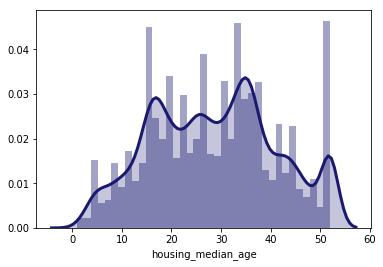

In [7]:
sns.distplot(housing['housing_median_age'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

A distribuição dos dados não é muito concentrada em nenhum extremo. Também não apresenta distribuição normal, que seria interessante para o uso em uma regressão linear.

##### Variável total_rooms

**_boxplot_**

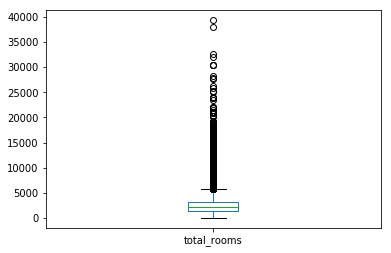

In [8]:
### total_rooms:
housing[['total_rooms']].boxplot(grid=False);

Para estes dados, obseva-se de fato uma concentração grande dos valores abaixo de 5000. Analisando o histograma:

**_density plot_**

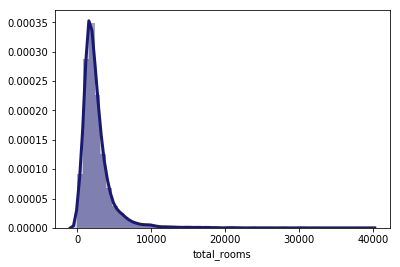

In [9]:
sns.distplot(housing['total_rooms'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

O gráfico de densidade confirma a concentração dos valores abaixo dos 5000. Se analisarmos a quantidade de registros para estas faixas:

In [10]:
print('Qtd de casas com total_rooms abaixo de 5k: ', housing[housing['total_rooms']<=5000]['median_house_value'].count())
print('Qtd de casas com total_rooms acima de 5k: ', housing[housing['total_rooms']>5000]['median_house_value'].count())

Qtd de casas com total_rooms abaixo de 5k:  18882
Qtd de casas com total_rooms acima de 5k:  1758


Cerca de 10% do total de registros desta variável apresenta valor acima de 5k. Vamos analisar este caso um pouco mais a fundo, comparando os dados de cada faixa contra a variável alvo:

**_Alterando os dados acima de 5k para receberem a mediana_**

In [11]:
limite = 5000
mediana = housing['total_rooms'].median()
housing['total_rooms_median'] = housing['total_rooms'].apply(lambda x: mediana if x > limite else x)

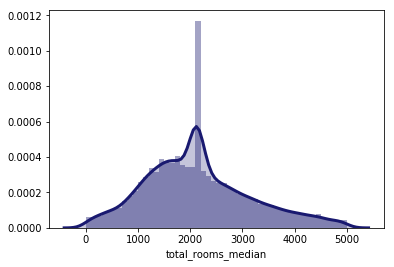

In [12]:
sns.distplot(housing['total_rooms_median'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

Os dados apresentam uma forma normal de distribuição, mas uma grande concentração nos valores transformados pela mediana

**_Alterando os dados para uma transformação logarítmica:_**

A distribuição extremamente concentrada dos dados originais da variável 'total_rooms', lembrando uma queda exponencial, leva a considerar a possiblidade de realizar uma transformação logaritmica nos dados que, para esta situação, usualmente transforma os dados para uma distribuição normal. Aplicando a transformação e analisando o histograma dos resultados:

In [13]:
housing['total_rooms_log'] = housing['total_rooms'].apply(np.log)

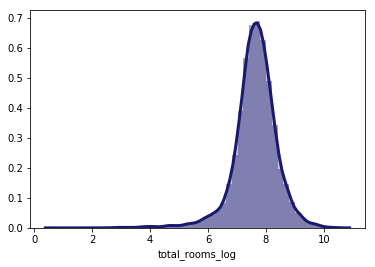

In [14]:
sns.distplot(housing['total_rooms_log'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

##### Variável total_bedrooms

**_boxplot_**

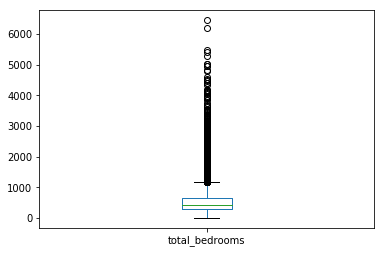

In [15]:
### housing_median_age:
housing[['total_bedrooms']].boxplot(grid=False);

Estes dados parecem ter forma muito similar aos dados da variável total_rooms. Isto é esperado, dado que a variável "_total rooms_" ("total de ambientes", ou algo próximo) realmente deve estar ligado à quantidade de quartos ("_total bedrooms_") nas casas. Esta possível correlação exploraremos posteriormente adiante.<br/>
Neste momento, vamos analisar o _density plot_ dos dados de "_total bedrooms_". Porém, vale lembrar que estes dados possuem valores nulos. Sabemos que são 207 registros nulos nesta variável, 1% do total dos dados. Poderíamos excluir estes dados, mas como é possível que haja uma correlação forte destes dados com a variável "_total rooms_", vamos criar uma marcação para estes pontos (para posterior exclusão, caso necessário), e também preencher os dados originais com a mediana:

In [16]:
# marcando valores nulos
housing['total_bedrooms_nulos'] = housing.total_bedrooms.apply(lambda x: True if math.isnan(x) 
                                                               else False)

# preenchendo com mediana
mediana = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(mediana, inplace=True)

**_density plot_**

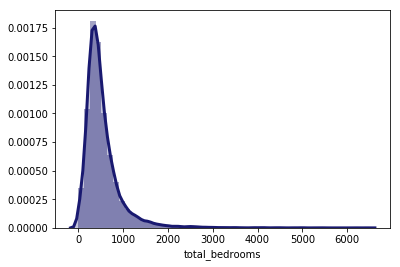

In [17]:
sns.distplot(housing['total_bedrooms'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

Confirmando a interpretação anterior, a distribuição dos dados é bastante similar à variável "_total rooms_". Vamos adotar os mesmos procedimentos que os anteriores, substituindo os valores acima de 1200 pela mediana e também uma nova variável com o tratamento da transformação logarítmica:

In [18]:
# troca dos outliers pela mediana:
limite = 1200
mediana = housing['total_bedrooms'].median()
housing['total_bedrooms_median'] = housing['total_bedrooms'].apply(lambda x: mediana if x > limite
                                                                   else x)

# transformação logaritmica:
housing['total_bedrooms_log'] = housing['total_bedrooms'].apply(np.log)

Plotando a distribuição dos dados:

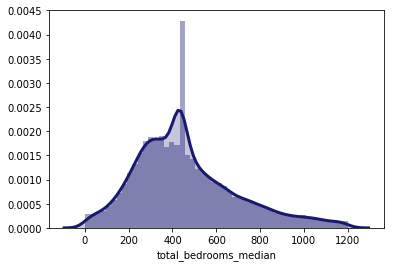

In [19]:
# dados outliers substituídos pela mediana
sns.distplot(housing['total_bedrooms_median'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

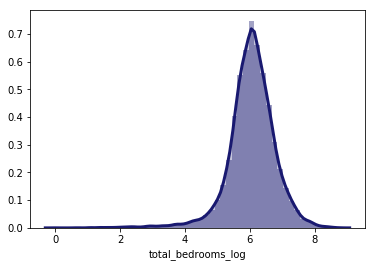

In [20]:
# dados transformados pelo logaritmo:
sns.distplot(housing['total_bedrooms_log'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

##### Variável population

**_boxplot_**

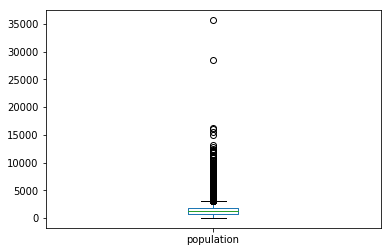

In [21]:
### population:
housing[['population']].boxplot(grid=False);

Novamente, parece ser o caso de uma distribuição bastante concentrada à esquerda. Vamos analisar o _density plot_:

**_density plot_**

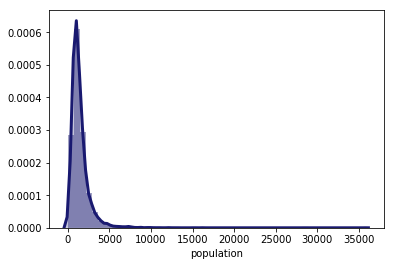

In [22]:
# dados transformados pelo logaritmo:
sns.distplot(housing['population'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

Pela similaridade dos dados, vamos diretamente aplicar os mesmos tratamentos anteriores:

** Alterando dados para para trocar valores extremos pela mediana e aplicando transformação logaritima: **

In [23]:
# troca dos outliers pela mediana:
limite = 4000
mediana = housing['population'].median()
housing['population_median'] = housing['population'].apply(lambda x: mediana if x > limite
                                                                   else x)

# transformação logaritmica:
housing['population_log'] = housing['population'].apply(np.log)

E, plotando as distribuições:

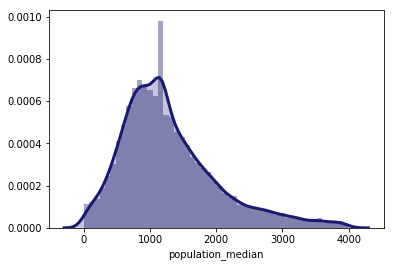

In [24]:
# dados outliers substituídos pela mediana
sns.distplot(housing['population_median'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

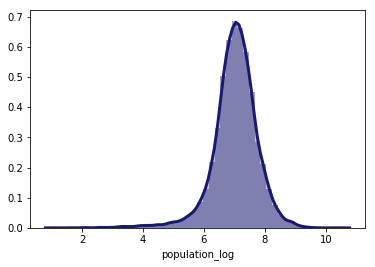

In [25]:
# dados transformados pelo logaritmo:
sns.distplot(housing['population_log'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

##### Variável households

**_boxplot_**

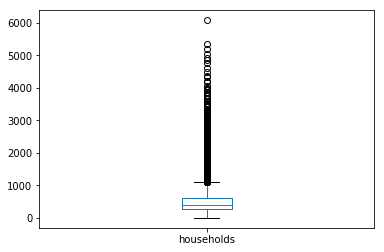

In [26]:
### households:
housing[['households']].boxplot(grid=False);

Novamente, pela similaridade dos dados, vamos aplicar diretamente os mesmos tratamentos anteriores:

In [27]:
# troca dos outliers pela mediana:
limite = 1000
mediana = housing['households'].median()
housing['households_median'] = housing['households'].apply(lambda x: mediana if x > limite
                                                                   else x)

# transformação logaritmica:
housing['households_log'] = housing['households'].apply(np.log)

E, plotando as distribuições:

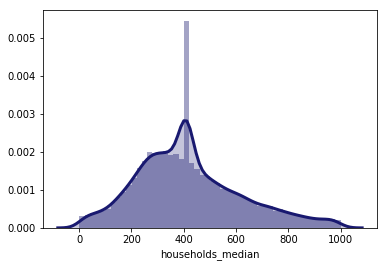

In [28]:
# dados outliers substituídos pela mediana
sns.distplot(housing['households_median'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

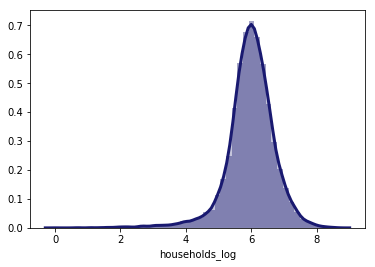

In [29]:
# dados transformados pelo logaritmo:
sns.distplot(housing['households_log'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

##### Variável median_income:

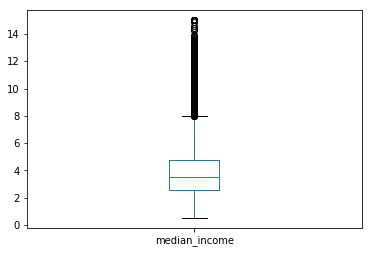

In [30]:
### households:
housing[['median_income']].boxplot(grid=False);

Neste caso, aparentemente os dados não estão tão concentrados como nos primeiros analisados. Vamos analisar a distribuição dos dados:

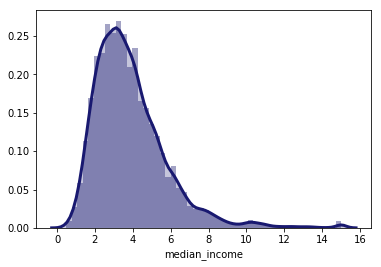

In [31]:
# distribuição dos dados:
sns.distplot(housing['median_income'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

Como esperado, os dados não apresentam uma concentração muito grande. Desta forma, vamos manter os dados da forma que estão, e se necessário aplicaremos transformações posteriores.

##### Variáveis Latitude e Longitude:

É possível imaginar que haja zonas onde o valor da casa seja maior ou menor. Portanto, além dos dados puros de latitude e longitude, podemos tentar criar áreas pela intersecção de linhas verticais e horizontais.
Primeiramente vamos plotar a posição x,y dos pontos em um gráfico de distribuição:

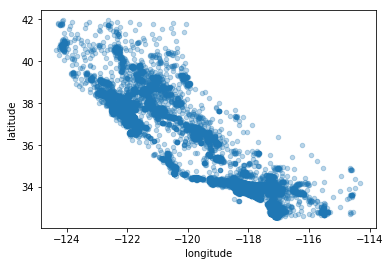

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3);

Aparentemente, é possível passar 3 faixas horizontais e 3 verticais, fazendo a divisão em 9 quadrantes:

In [33]:
Lat_N_Lim = 38
Lat_S_Lim = 36
Long_O_Lim = -120
Long_E_Lim = -118

E aplicamos a marcação para todos os pontos:

In [34]:
housing['classif_lat'] = housing.latitude.apply(lambda x: 'N' if x > Lat_N_Lim else
                                                'S' if x < Lat_S_Lim else 'C')
housing['classif_long'] = housing.longitude.apply(lambda x: 'O' if x < Long_O_Lim else
                                                  'E' if x > Long_E_Lim else 'C')
housing['zona'] = housing['classif_lat']+housing['classif_long']
del housing['classif_lat']
del housing['classif_long']

In [35]:
# Analisando as quantidades resultantes:
housing['zona'].value_counts()

SC    6451
SE    5076
CO    4936
NO    2976
CC     871
SO     287
NC      39
CE       4
Name: zona, dtype: int64

Pela quantidade de pontos e proximidade dos mesmos, vamos tratar as regiões CC, SO, NC e CE como 'Centrais' (C):

In [36]:
housing['zona'] = housing.zona.apply(lambda x: 'C' if x in ['CC', 'SO', 'NC', 'CE'] else x)

In [37]:
# Analisando as quantidades resultantes:
housing['zona'].value_counts()

SC    6451
SE    5076
CO    4936
NO    2976
C     1201
Name: zona, dtype: int64

##### Variável median_house_value (_target_):

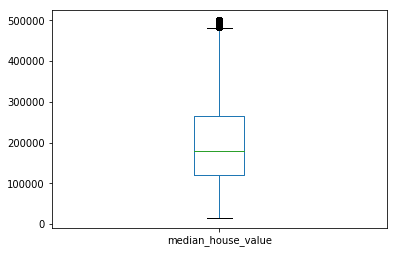

In [38]:
### median_house_values:
housing[['median_house_value']].boxplot(grid=False);

A variável target não parece ter extremos consideráveis. Vamos tentar confirmar pelo _density plot_ da variável target:

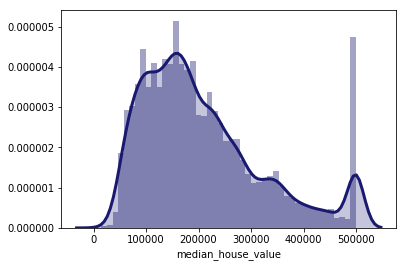

In [39]:
# distribuição dos dados:
sns.distplot(housing['median_house_value'], hist = True, kde = True, color='midnightblue', 
             kde_kws = {'shade': True, 'linewidth': 3});

Diferentemente do que o boxplot sugeria, observa-se uma concentração de vários pontos no valor extremo de 500k. Este fator será complicador para nosso trabalho, dado que este degrau terá dificuldade de ser compreendido pela regressão.

### Normalização dos Dados

Com os valore extremos tratados, podemos agora passar para a normalização dos dados. Portanto, aplicando nas variáveis numéricas trabalhadas:

In [40]:
num_vars = ['housing_median_age', 'total_rooms_median', 'total_rooms_log', 
            'total_bedrooms_median', 'total_bedrooms_log', 'population_median', 
            'population_log', 'households_median', 'households_log', 'median_income',
            'median_house_value', 'latitude', 'longitude']

Antes, porém, vamos armazenar os valores mínimo e máximo da variável target para podermos voltar a seu valor original posteriormente:

In [41]:
housing['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [42]:
preditora_min = housing['median_house_value'].describe()['min']
preditora_max = housing['median_house_value'].describe()['max']

In [43]:
for feature_name in housing[num_vars]:
    max_value = housing[feature_name].max()
    min_value = housing[feature_name].min()
    housing[feature_name] = (housing[feature_name] - min_value) / (max_value - min_value)

In [44]:
housing[num_vars].head()

,housing_median_age,total_rooms_median,total_rooms_log,total_bedrooms_median,total_bedrooms_log,population_median,population_log,households_median,households_log,median_income,median_house_value,latitude,longitude
0,0.784314,0.175705,0.615675,0.106756,0.554074,0.079890,0.498300,0.125125,0.555059,0.539668,0.902266,0.567481,0.211155
1,0.392157,0.425255,0.826854,0.921601,0.799049,0.600551,0.712402,0.408408,0.807639,0.538027,0.708247,0.565356,0.212151
2,1.000000,0.293176,0.667368,0.157631,0.598220,0.123466,0.544339,0.176176,0.594066,0.466028,0.695051,0.564293,0.210159
3,1.000000,0.254553,0.653100,0.195163,0.622454,0.138993,0.556891,0.218218,0.618503,0.354699,0.672783,0.564293,0.209163
4,1.000000,0.325195,0.677839,0.232694,0.642430,0.140746,0.558219,0.258258,0.637756,0.230776,0.674638,0.564293,0.209163


### Análise de Correlação - Entre variáveis Preditoras Contínuas

Vamos analisar as variáveis contínuas tratadas com a mediana ou sem tratamento:

In [45]:
num_vars_median = ['housing_median_age', 'total_rooms_median', 'total_bedrooms_median', 
                   'population_median', 'households_median', 'median_income']

In [46]:
housing[num_vars_median].corr()

,housing_median_age,total_rooms_median,total_bedrooms_median,population_median,households_median,median_income
housing_median_age,1.000000,-0.243686,-0.232638,-0.251450,-0.194384,-0.119034
total_rooms_median,-0.243686,1.000000,0.764259,0.598722,0.785199,0.188995
total_bedrooms_median,-0.232638,0.764259,1.000000,0.727513,0.882013,-0.039256
population_median,-0.251450,0.598722,0.727513,1.000000,0.710484,-0.023884
households_median,-0.194384,0.785199,0.882013,0.710484,1.000000,-0.016300
median_income,-0.119034,0.188995,-0.039256,-0.023884,-0.016300,1.000000


Observamos que há correlações moderadas/fortes entre as variáveis "_total rooms median_", "_total bedrooms median_", "_households median_" e "_population median_". As variáveis "_housing age median_" e "_median income_", por outro lado, não apresentam relação forte com nenhuma outra variável.

Analisando agora as variáveis contínuas tratadas com a transformação logaritmica:

In [47]:
num_vars_log = ['housing_median_age', 'total_rooms_log', 'total_bedrooms_log', 
                   'population_log', 'households_log', 'median_income']

In [48]:
housing[num_vars_log].corr()

,housing_median_age,total_rooms_log,total_bedrooms_log,population_log,households_log,median_income
housing_median_age,1.000000,-0.314723,-0.269370,-0.243673,-0.241422,-0.119034
total_rooms_log,-0.314723,1.000000,0.941687,0.864888,0.931849,0.205660
total_bedrooms_log,-0.269370,0.941687,1.000000,0.893178,0.969761,-0.025620
population_log,-0.243673,0.864888,0.893178,1.000000,0.932340,-0.004967
households_log,-0.241422,0.931849,0.969761,0.932340,1.000000,0.003456
median_income,-0.119034,0.205660,-0.025620,-0.004967,0.003456,1.000000


Confirma-se o mesmo entendimento anterior para as variáveis tratadas com a mediana, mas com valores ainda mais fortes. Isto significa que estamos tratando basicamente da mesma informação e, portanto, possivelmente, teremos que optar por manter somente uma das três variáveis acima para o treinamento da regressão.

Vamos agora analisar se há relação entre a variável "_Ocean Proximity_" e demais numéricas contínuas:

In [49]:
ocean_classes = housing['ocean_proximity'].drop_duplicates().to_list()

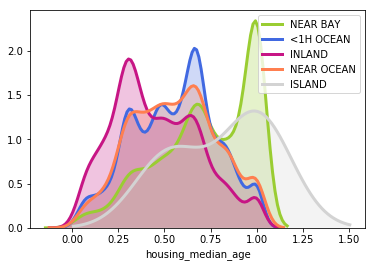

In [50]:
# variável HOUSING MEDIAN AGE:
count = -1
colors = ['yellowgreen', 'royalblue', 'mediumvioletred', 'coral', 'lightgrey']
for ent in ocean_classes:
    count += 1
    values = housing[housing['ocean_proximity']==ent]['housing_median_age']
    sns.distplot(values, hist = False, kde = True, label=ent,
                 color=colors[count], kde_kws = {'shade': True, 'linewidth': 3});
    plt.legend()

Aparentemente, as casas próximas à baía ou na ilha são mais antigas que as demais casas. Portanto, pode fazer sentido criarmos uma nova variável 'old_house_near_bay_island', que represente esta combinação de variabilidades:

In [51]:
limite_old = 0.9
housing['old_house_bay_island'] = \
list(map(lambda x,y: 'Y' if x in ['NEAR BAY', 'ISLAND'] and y >= limite_old
    else 'N', housing['ocean_proximity'], housing['housing_median_age']))

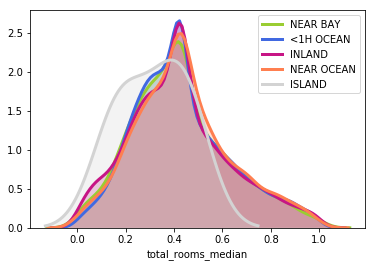

In [52]:
# variável TOTAL ROOMS MEDIAN:
count = -1
colors = ['yellowgreen', 'royalblue', 'mediumvioletred', 'coral', 'lightgrey']
for ent in ocean_classes:
    count += 1
    values = housing[housing['ocean_proximity']==ent]['total_rooms_median']
    sns.distplot(values, hist = False, kde = True, label=ent,
                 color=colors[count], kde_kws = {'shade': True, 'linewidth': 3});
    plt.legend()

Por outro lado, aparentemente NÃO há relação entre a proximidade do oceano com a quantidade de ambientes. Como a informação TOTAL ROOMS é basicamente a mesma que a das variáveis "total rooms median", "total bedrooms median", "households median" e "population median", não repetiremos a análise para estas variáveis

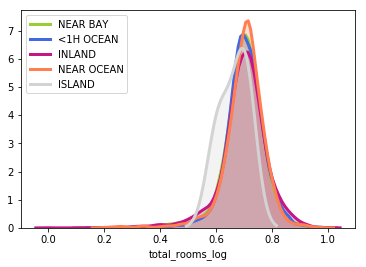

In [53]:
# variável TOTAL ROOMS LOG:
count = -1
colors = ['yellowgreen', 'royalblue', 'mediumvioletred', 'coral', 'lightgrey']
for ent in ocean_classes:
    count += 1
    values = housing[housing['ocean_proximity']==ent]['total_rooms_log']
    sns.distplot(values, hist = False, kde = True, label=ent,
                 color=colors[count], kde_kws = {'shade': True, 'linewidth': 3});
    plt.legend()

A mesma conclusão é obtida comparando a mesma variável com a respectiva transformações logaritmica.

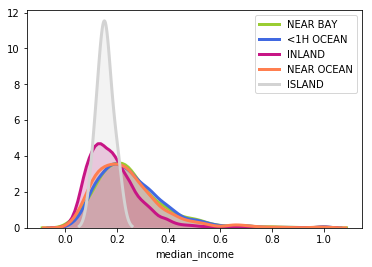

In [54]:
# variável MEDIAN INCOME:
count = -1
colors = ['yellowgreen', 'royalblue', 'mediumvioletred', 'coral', 'lightgrey']
for ent in ocean_classes:
    count += 1
    values = housing[housing['ocean_proximity']==ent]['median_income']
    sns.distplot(values, hist = False, kde = True, label=ent,
                 color=colors[count], kde_kws = {'shade': True, 'linewidth': 3});
    plt.legend()

Aparentemente a variável 'Median Income' apresenta mais concentração em torno de 0,2 quando se olha na 'Island' do que nas demais localidades (quase não há registros de renda média mais alta na ilha). Portanto, talvez faça sentido criar uma nova variável binária "island_low_income", onde os valores serão classificados acima ou abaixo de 0.2, para tentar destacar esta relação.

In [55]:
housing['island_low_income'] = housing.median_income.apply(lambda x: 'Y' if x<=0.2 else 'N')

### Análise de Correlação - Entre variáveis Contínuas Preditoras e Variável Target

**Variáveis "_housing median age_" e "_median house value_"**

In [56]:
housing[['housing_median_age','median_house_value']].corr()

,housing_median_age,median_house_value
housing_median_age,1.000000,0.105623
median_house_value,0.105623,1.000000


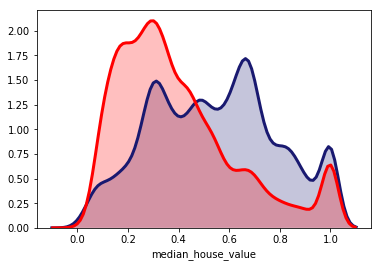

In [57]:
# distribuição dos dados:
sns.distplot(housing['housing_median_age'], hist = False, kde = True,
             color='midnightblue', kde_kws = {'shade': True, 'linewidth': 3});
sns.distplot(housing['median_house_value'], hist = False, kde = True, 
             color='red', kde_kws = {'shade': True, 'linewidth': 3});

As linhas vermelha são as variáveis alvo, e a azul é a "_housing median age_".
Parece não haver correlação forte entre estas duas variáveis, e dificilmente esta será uma boa variável preditora. Entranto, nota-se uma sobreposição nos valores extremos da "housing age" e o "median house value", à qual vale estar atento.

**Variáveis "_total rooms XYZ_" e "_median house value_"**

In [58]:
housing[['total_rooms_log', "total_bedrooms_log", "households_log",
         'median_house_value']].corr()['median_house_value']

total_rooms_log       0.159227
total_bedrooms_log    0.052675
households_log        0.073175
median_house_value    1.000000
Name: median_house_value, dtype: float64

Observa-se que, dentre as variáveis "total_room", a que parece mais colaborar com a predição do modelo é a "_total rooms log_". Analisando as sobreposições respecitivas no gráfico:

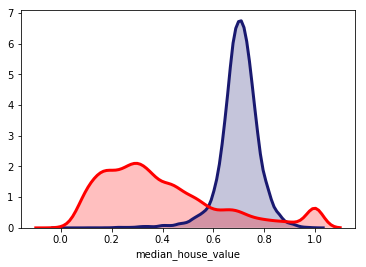

In [59]:
# distribuição dos dados:
sns.distplot(housing['total_rooms_log'], hist = False, kde = True,
             color='midnightblue', kde_kws = {'shade': True, 'linewidth': 3});
sns.distplot(housing['median_house_value'], hist = False, kde = True, 
             color='red', kde_kws = {'shade': True, 'linewidth': 3});

Como esperado, dada a baixa correlação obtida, o formato do gráficos parece não ter alta correlação. Desta forma, é esperado que esta não seja uma boa variável preditora.

** Variáveis "_median income_" e "_median house value_"**

In [60]:
housing[['median_income', 'median_house_value']].corr()

,median_income,median_house_value
median_income,1.000000,0.688075
median_house_value,0.688075,1.000000


Esta mostra-se a variável com o maior correlação com a variável alvo. Teoricamente, faz sentido o preço das casas ser influenciado pelo valor da renda local. Analisando  visualmente:

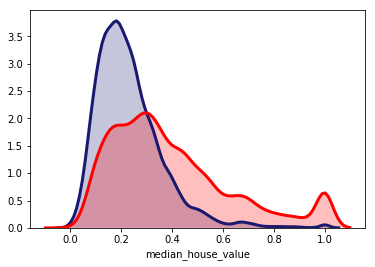

In [61]:
# distribuição dos dados:
sns.distplot(housing['median_income'], hist=False, kde = True,
             color='midnightblue', kde_kws = {'shade': True, 'linewidth': 3});
sns.distplot(housing['median_house_value'], hist=False, kde = True, 
             color='red', kde_kws = {'shade': True, 'linewidth': 3});

### Análise de Correlação - Entre variáveis Categóricas e Variável Target

**Variável "_ocean proximity_"**

Vamos analisar os valores médios da variável "_median house value_" e analisar se este tem diferença sensível. Para isto, vamos fazer os testes T dois a dois:

In [62]:
# gravar as classes em uma lista específica:
ocean_classes = housing['ocean_proximity'].drop_duplicates().to_list()

In [63]:
# comparar todas as classes com o valor geral da variável do valor
for var in ocean_classes:
    a = housing[housing['ocean_proximity']==var]['median_house_value']
    b = housing['median_house_value']
    print(var, ': ', ttest_ind(a,b, equal_var = False))

NEAR BAY :  Ttest_indResult(statistic=19.468583174808135, pvalue=3.335805642741405e-79)
<1H OCEAN :  Ttest_indResult(statistic=24.247846312829143, pvalue=6.232682642886588e-128)
INLAND :  Ttest_indResult(statistic=-69.51158133377102, pvalue=0.0)
NEAR OCEAN :  Ttest_indResult(statistic=16.97871409804316, pvalue=4.782409916688653e-62)
ISLAND :  Ttest_indResult(statistic=4.816927939783414, pvalue=0.008520878346500454)



Observamos que o p-valor calculado para todas as classes, quando comparadas com a classe geral, apresentam valores bem abaixo dos p de mercado (0,05 ou 0,01, quando mais rígidos). Portanto, temos a certeza que a variável  "_Ocean Proximity_" influencia no preço das casas.

**Variável "_zona_"**

Aplicando o mesmo teste anterior, temos:

In [64]:
# gravar as classes em uma lista específica:
zona_classes = housing['zona'].drop_duplicates().to_list()

In [65]:
# comparar todas as classes com o valor geral da variável do valor
for var in zona_classes:
    a = housing[housing['zona']==var]['median_house_value']
    b = housing['median_house_value']
    print(var, ': ', ttest_ind(a,b, equal_var = False))

CO :  Ttest_indResult(statistic=21.600832474395816, pvalue=2.611560908428209e-100)
C :  Ttest_indResult(statistic=-43.153613640701664, pvalue=2.233498373843789e-271)
NO :  Ttest_indResult(statistic=-49.3231105462606, pvalue=0.0)
SE :  Ttest_indResult(statistic=-9.635402408731574, pvalue=7.285257882631322e-22)
SC :  Ttest_indResult(statistic=18.270620661470414, pvalue=1.908147572762364e-73)


Da mesma forma que no caso anterior, vemos que o p-valor calculado para todas as classes, quando comparadas com a classe geral, apresentam valores bem abaixo dos p de mercado (0,05 ou 0,01, quando mais rígidos). Portanto, temos a certeza que a variável "Zona" influencia no preço das casas.

**Variável "_old house bay island_"**

Vamos analisar a variável criada e entender se há diferença significativa entre os valores médios na nossa variável alvo. Caso haja, é provável que esta seja uma boa variável preditora.

In [66]:
# comparar todas as classes com o valor geral da variável do valor
a = housing[housing['old_house_bay_island']=='Y']['median_house_value']
b = housing[housing['old_house_bay_island']=='N']['median_house_value']
ttest_ind(a,b, equal_var = False)

Ttest_indResult(statistic=18.761466404033136, pvalue=5.241077364548167e-66)

Vemos que há diferenças significativas, pois o p-valor calculado é muito próximo de zero, indicando que a diferença dos valores tem probabilidade quase zero de que a diferença média dos preços seja devida ao acaso.

Variável "**_island low income_**"

De forma similar ao caso anterior, vamos analisar a variável criada e tentar deduzir se é uma boa variável preditora:

In [67]:
# comparar todas as classes com o valor geral da variável do valor
a = housing[housing['island_low_income']=='Y']['median_house_value']
b = housing[housing['island_low_income']=='N']['median_house_value']
ttest_ind(a,b, equal_var = False)

Ttest_indResult(statistic=-86.25014129565584, pvalue=0.0)

A conclusão é que o p-valor obtido (0) também permite concluir, com quase de 100% de certeza, que a diferença no preço médio das casas entre os 'Y'/'N' da variável também não é por acaso.

### Variáveis Categóficas - Criação das variáveis _dummy_

**Variável "_ocean proximity_"**

In [68]:
y = pd.get_dummies(housing.ocean_proximity, prefix='ocean_proximity')

In [69]:
housing = housing.merge(y, left_index=True, right_index=True)

**Variável "_zona_"**

In [70]:
y = pd.get_dummies(housing.zona, prefix='zona')

In [71]:
housing = housing.merge(y, left_index=True, right_index=True)

**Variável "_old house bay island_"**

In [72]:
y = pd.get_dummies(housing.old_house_bay_island, prefix='old_bay_island')

In [73]:
housing = housing.merge(y, left_index=True, right_index=True)

**Variável "_island low income_"**

In [74]:
y = pd.get_dummies(housing.island_low_income, prefix='island_low_income')

In [75]:
housing = housing.merge(y, left_index=True, right_index=True)

### Divisão dos dados em treino e teste

Para realizar o treino e medir efetivamente os resultados em dados não vistos anteriormente, como em uma aplicação real, vamos dividir os dados entre treino e teste.

In [76]:
variveis_preditoras = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                       'households', 'median_income', 'ocean_proximity', 'latitude', 'longitude',
                       'total_rooms_median', 'total_rooms_log', 'total_bedrooms_nulos', 
                       'total_bedrooms_median', 'total_bedrooms_log', 'population_median',
                       'population_log', 'households_median', 'households_log', 
                       'old_house_bay_island', 'island_low_income', 'zona', 
                       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 
                       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 
                       'ocean_proximity_NEAR OCEAN', 'zona_C', 'zona_CO', 'zona_NO', 
                       'zona_SC', 'zona_SE', 'old_bay_island_N', 'old_bay_island_Y', 
                       'island_low_income_N', 'island_low_income_Y']
variavel_target = ['median_house_value']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(housing[variveis_preditoras], 
                                                    housing[variavel_target],
                                                    test_size=0.2, random_state=42)

Vamos analisar a forma das curvas e comparar as médias para entender se a divisão está representando bem os dados da variável target:

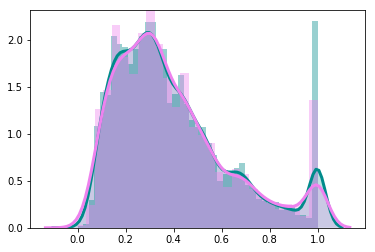

In [78]:
sns.distplot(y_train, kde = True, 
             color='darkcyan', kde_kws = {'shade': True, 'linewidth': 3});
sns.distplot(y_test, kde = True, 
             color='violet', kde_kws = {'shade': True, 'linewidth': 3});

In [79]:
#comparar todas as classes com o valor geral da variável do valor
ttest_ind(y_train,y_test, equal_var = False)

Ttest_indResult(statistic=array([0.84880225]), pvalue=array([0.3960231]))

Nota-se que a divisão dos dados em treino e teste manteve a exata mesma forma das curvas. Ou seja, os dados representam bem um e outro. O teste do valor médio também impossibilita de longe rejeitar a hipótese nula (de que as médias entre os dois conjuntos são diferentes), o que é um bom sinal de nossa divisão.

### Treino da Regressão Linear

Vamos neste momento fazer o treino da regressão linear com as variáveis todas as variáveis não tratadas e tentar fazer alterações para chegar ao melhor modelo possível. Assim:

In [80]:
X_train.columns

Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income', 'ocean_proximity', 'latitude',
       'longitude', 'total_rooms_median', 'total_rooms_log',
       'total_bedrooms_nulos', 'total_bedrooms_median', 'total_bedrooms_log',
       'population_median', 'population_log', 'households_median',
       'households_log', 'old_house_bay_island', 'island_low_income', 'zona',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'zona_C', 'zona_CO', 'zona_NO', 'zona_SC',
       'zona_SE', 'old_bay_island_N', 'old_bay_island_Y',
       'island_low_income_N', 'island_low_income_Y'],
      dtype='object')

In [81]:
variaveis_pred_filtro = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
                         'households', 'median_income', 'latitude',
                         'longitude', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
                         'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
                         'ocean_proximity_NEAR OCEAN', 'old_bay_island_N', 'old_bay_island_Y',
                         'island_low_income_N', 'island_low_income_Y']
X_train_f = X_train[variaveis_pred_filtro]
X_test_f = X_test[variaveis_pred_filtro]

In [82]:
y_test = y_test * (preditora_max - preditora_min) + preditora_min

In [86]:
# Professor, por algum motivo meu computador nunca roda esta célula de primeira. Caso aconteça com o sr.,
# peço pf que altere o parâmetro fit_intercept abaixo para True, execute e célula e volte novamente para False,
# executando novamente. Isto somente acontece uma vez, mas não consegui resolver.
reg = LinearRegression(normalize=False, fit_intercept=False).fit(X_train_f, y_train)

In [87]:
y_pred = reg.predict(X_test_f) * (preditora_max - preditora_min) + preditora_min

In [88]:
rms = math.sqrt(mean_squared_error(y_test, y_pred))
print(rms)

69577.6650528159


Vemos aqui que o uso das variáveis originais aproxima do valor de RMS esperado, mas não foi o suficiente. Vamos tentar fazer a substituição das variáveis contínuas pelas alteradas pela mediana e analisar o resultado:

In [89]:
variaveis_pred_filtro = ['housing_median_age', 'total_rooms_median', 'total_bedrooms_median', 
                        'population_median', 'households_median',
                         'median_income', 'latitude', 'longitude',
                         'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
                         'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
                         'ocean_proximity_NEAR OCEAN']
X_train_f = X_train[variaveis_pred_filtro]
X_test_f = X_test[variaveis_pred_filtro]

In [90]:
reg = LinearRegression(normalize=False, fit_intercept=False).fit(X_train_f, y_train)
y_pred = reg.predict(X_test_f) * (preditora_max - preditora_min) + preditora_min
rms = math.sqrt(mean_squared_error(y_test, y_pred))
print(rms)

71461.81761742587


Vemos aqui que a troca dos valores para a Mediana acabou na realidade piorando o resultado! Se utilizarmos os valores alterados pela transformação logarítima:

In [91]:
variaveis_pred_filtro = ['housing_median_age', 'total_rooms_log', 'total_bedrooms_log', 
                        'population_log', 'households_log',
                         'median_income', 'latitude', 'longitude',
                         'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
                         'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
                         'ocean_proximity_NEAR OCEAN']
X_train_f = X_train[variaveis_pred_filtro]
X_test_f = X_test[variaveis_pred_filtro]

In [92]:
reg = LinearRegression(normalize=False, fit_intercept=False).fit(X_train_f, y_train)
y_pred = reg.predict(X_test_f) * (preditora_max - preditora_min) + preditora_min
rms = math.sqrt(mean_squared_error(y_test, y_pred))
print(rms)

69434.50767825471


Vemos que o resultado melhorou muito em relação à mediana e também levemente em relação aos dados originais. Se mantivermos os valores transformados e incluirmos as variáveis auxiliares criadas:

In [93]:
variaveis_pred_filtro = ['housing_median_age', 'total_rooms_log', 'total_bedrooms_log', 
                        'population_log', 'households_log',
                         'median_income', 'latitude', 'longitude',
                         'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
                         'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
                         'zona_C', 'zona_CO', 'zona_NO', 'zona_SC',
                         'zona_SE', 'old_bay_island_N', 'island_low_income_Y']
X_train_f = X_train[variaveis_pred_filtro]
X_test_f = X_test[variaveis_pred_filtro]

In [94]:
reg = LinearRegression(normalize=False, fit_intercept=False).fit(X_train_f, y_train)
y_pred = reg.predict(X_test_f) * (preditora_max - preditora_min) + preditora_min
rms = math.sqrt(mean_squared_error(y_test, y_pred))
print(rms)

67290.19790621944


**Neste ponto, já vemos que houve uma melhora sensível, de cerca de 2000 no RMS**. Ainda, se lembrarmos que algumas variáveis têm forte correlação, e fazendo algumas tentativas, obtemos:

In [95]:
variaveis_pred_filtro = ['housing_median_age', 'median_income', 'latitude', 'longitude', 
                         'population_log', 'households_log', 'ocean_proximity_<1H OCEAN', 
                         'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
                         'ocean_proximity_NEAR OCEAN', 'zona_C', 'zona_CO', 'zona_NO', 'zona_SC',
                         'zona_SE', 'old_bay_island_N', 'island_low_income_Y']
X_train_f = X_train[variaveis_pred_filtro]
X_test_f = X_test[variaveis_pred_filtro]

In [96]:
reg = LinearRegression(normalize=False, fit_intercept=False).fit(X_train_f, y_train)

In [97]:
y_pred = reg.predict(X_test_f) * (preditora_max - preditora_min) + preditora_min

In [98]:
rms = math.sqrt(mean_squared_error(y_test, y_pred))
print(rms)

66027.2260814089


** Com este resultado (66,0k) de RMS, este foi o melhor modelo que pudemos obter! ** O resultado foi cerca de 3k abaixo do estabelecido para o problema

Se analisarmos a relevância das variáveis (vamos tratar em módulo para facilitar a análise):

In [99]:
coeficientes = list(reg.coef_)[0]
for i in range(0,18):
    print('Var "', variaveis_pred_filtro[i], '": ', abs(coeficientes[i]))

Var " housing_median_age ":  0.050248693970104404
Var " median_income ":  1.1095543759332689
Var " latitude ":  0.3739756436873484
Var " longitude ":  0.4071594767223677
Var " population_log ":  1.8722646708025121
Var " households_log ":  1.794308944954724
Var " ocean_proximity_<1H OCEAN ":  0.22695446707320122
Var " ocean_proximity_INLAND ":  0.15185090434182566
Var " ocean_proximity_ISLAND ":  0.45006094466001867
Var " ocean_proximity_NEAR BAY ":  0.19091388983183813
Var " ocean_proximity_NEAR OCEAN ":  0.2449405582537855
Var " zona_C ":  0.20708447523547982
Var " zona_CO ":  0.28260862719168367
Var " zona_NO ":  0.23368622514535037
Var " zona_SC ":  0.30257961772179415
Var " zona_SE ":  0.2387618188663675
Var " old_bay_island_N ":  0.09405296442093682
Var " island_low_income_Y ":  0.00016274984274589066


Aqui podemos ver que as variáveis mais relevantes para o modelo são population, households e median_income. É interessante e curioso perceber que, embora haja uma alta correlação entre as variáveis population e households, a ausência de uma delas prejudica grandemente o modelo. 
A variável 'Zona' auxilia bastante o modelo, e sua criação auxiliou de forma relevante o resultado final. A variável old_bay_island teve relevância mediana. Por outro lado, a variável island_low_income criada se mostrou praticamente irrelevante, e sua permanência pouco auxilia o modelo, a despeito do estudo realizado.

Por fim, visualizando a predição vs. os dados reais:

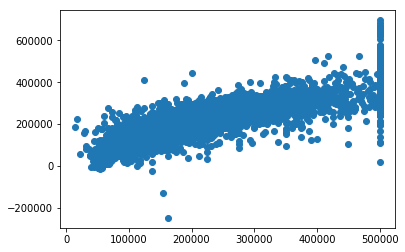

In [100]:
plt.scatter(y_test, y_pred);

É possível ver que os dados em torno dos 500k prejudicam o modelo, concentrando grande parte dos erros ali. Também é importante notar que o modelo apresentou alguns erros de predição como valores negativos, que deveriam ter tratamento adicional para correção.